In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import xgboost
import shap

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

In [2]:
p_karst_with_controls = gpd.read_file('temp_p_karst_with_controls_5070.shp')
p_karst_with_controls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29068 entries, 0 to 29067
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    29068 non-null  float64 
 1   tnmid       29068 non-null  object  
 2   metasource  11319 non-null  object  
 3   sourcedata  655 non-null    object  
 4   sourceorig  675 non-null    object  
 5   sourcefeat  0 non-null      float64 
 6   loaddate    29011 non-null  object  
 7   referenceg  174 non-null    object  
 8   areaacres   29068 non-null  float64 
 9   areasqkm    29068 non-null  float64 
 10  states      29068 non-null  object  
 11  huc12       29068 non-null  object  
 12  name        29068 non-null  object  
 13  hutype      29068 non-null  object  
 14  humod       29060 non-null  object  
 15  tohuc       29068 non-null  object  
 16  noncontrib  27978 non-null  float64 
 17  noncontr_1  27898 non-null  float64 
 18  globalid    29068 non-null  object  
 

In [3]:
p_karst_with_controls.keys()

Index(['objectid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig',
       'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm',
       'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib',
       'noncontr_1', 'globalid', 'shape_Leng', 'shape_Area', 'p_karst',
       'mean annua', 'annual pre', 'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 'dominant_r',
       'exposure_i', 'huc_carb_i', 'huc_pct_ar', 'median_slo', 'max_elev',
       'min_elev', 'f_steep', 'geometry'],
      dtype='object')

In [4]:
full_names = {'mean annua':'Mean annual temp', 'annual pre':'Annual precipitation', 
              'precipitat':'Precipitation seasonality', 'net primar':'Net primary production',
              'cmi mean':'CMI mean', 'carbonate':'Soil Carbonate', 'clay':'Soil clay', 
              'ph':'Soil pH', 'sand':'Soil sand', 'silt':'Soil silt', 'exposure_i':'Bedrock exposure',
               'huc_carb_i':'Bedrock carbonate index',  'median_slo':'Median slope', 'max_elev':'Max elevation',
               'organic ma':'Soil organic matter'
}
p_karst_with_controls.rename(mapper=full_names, axis=1, inplace=True)
p_karst_with_controls.keys()

Index(['objectid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig',
       'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm',
       'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib',
       'noncontr_1', 'globalid', 'shape_Leng', 'shape_Area', 'p_karst',
       'Mean annual temp', 'Annual precipitation', 'Precipitation seasonality',
       'Net primary production', 'CMI mean', 'Soil Carbonate', 'Soil clay',
       'Soil organic matter', 'Soil pH', 'Soil sand', 'Soil silt',
       'dominant_r', 'Bedrock exposure', 'Bedrock carbonate index',
       'huc_pct_ar', 'Median slope', 'Max elevation', 'min_elev', 'f_steep',
       'geometry'],
      dtype='object')

In [179]:
XY = p_karst_with_controls.loc[:, ['Mean annual temp', 'Annual precipitation', 'Precipitation seasonality',
       'Net primary production', 'CMI mean', 'Soil Carbonate', 'Soil clay',
       'Soil pH', 'Soil sand', 'Soil silt', 
       'Bedrock carbonate index', 
       'Median slope', 'Max elevation', 'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['Mean annual temp', 'Annual precipitation', 'Precipitation seasonality',
       'Net primary production', 'CMI mean', 'Soil Carbonate', 'Soil clay',
       'Soil pH', 'Soil sand', 'Soil silt', 
       'Bedrock carbonate index', 
       'Median slope', 'Max elevation'
         ]]


#Y = np.log10(XY.p_karst)
#X['dominant_r'] = X['dominant_r'].astype('category')
Y = XY.p_karst > 0
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29063 entries, 0 to 29067
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Mean annual temp           29063 non-null  float64
 1   Annual precipitation       29063 non-null  float64
 2   Precipitation seasonality  29063 non-null  float64
 3   Net primary production     29063 non-null  float64
 4   CMI mean                   29063 non-null  float64
 5   Soil Carbonate             29063 non-null  float64
 6   Soil clay                  29063 non-null  float64
 7   Soil pH                    29063 non-null  float64
 8   Soil sand                  29063 non-null  float64
 9   Soil silt                  29063 non-null  float64
 10  Bedrock carbonate index    29063 non-null  float64
 11  Median slope               29063 non-null  float64
 12  Max elevation              29063 non-null  float64
dtypes: float64(13)
memory usage: 3.1 MB


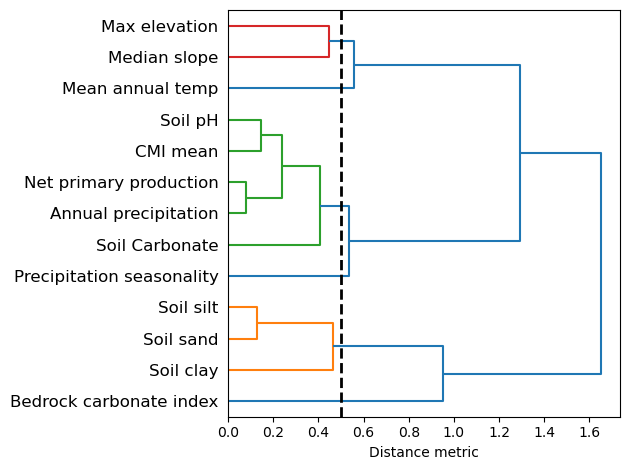

In [180]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), orientation='right', leaf_rotation=0, color_threshold=0.5,
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
plt.plot([0.5,0.5],[0,130], '--k', lw=2)
plt.xlabel('Distance metric')
plt.tight_layout()
#ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
#ax2.set_xticks(dendro_idx)
#ax2.set_yticks(dendro_idx)
#ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
#ax2.set_yticklabels(dendro["ivl"])
#_ = fig.tight_layout()

In [69]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]
X_sel = X[selected_features_names]
selected_features_names

Index(['Mean annual temp', 'Annual precipitation', 'Precipitation seasonality',
       'Soil clay', 'Bedrock carbonate index', 'Median slope'],
      dtype='object')

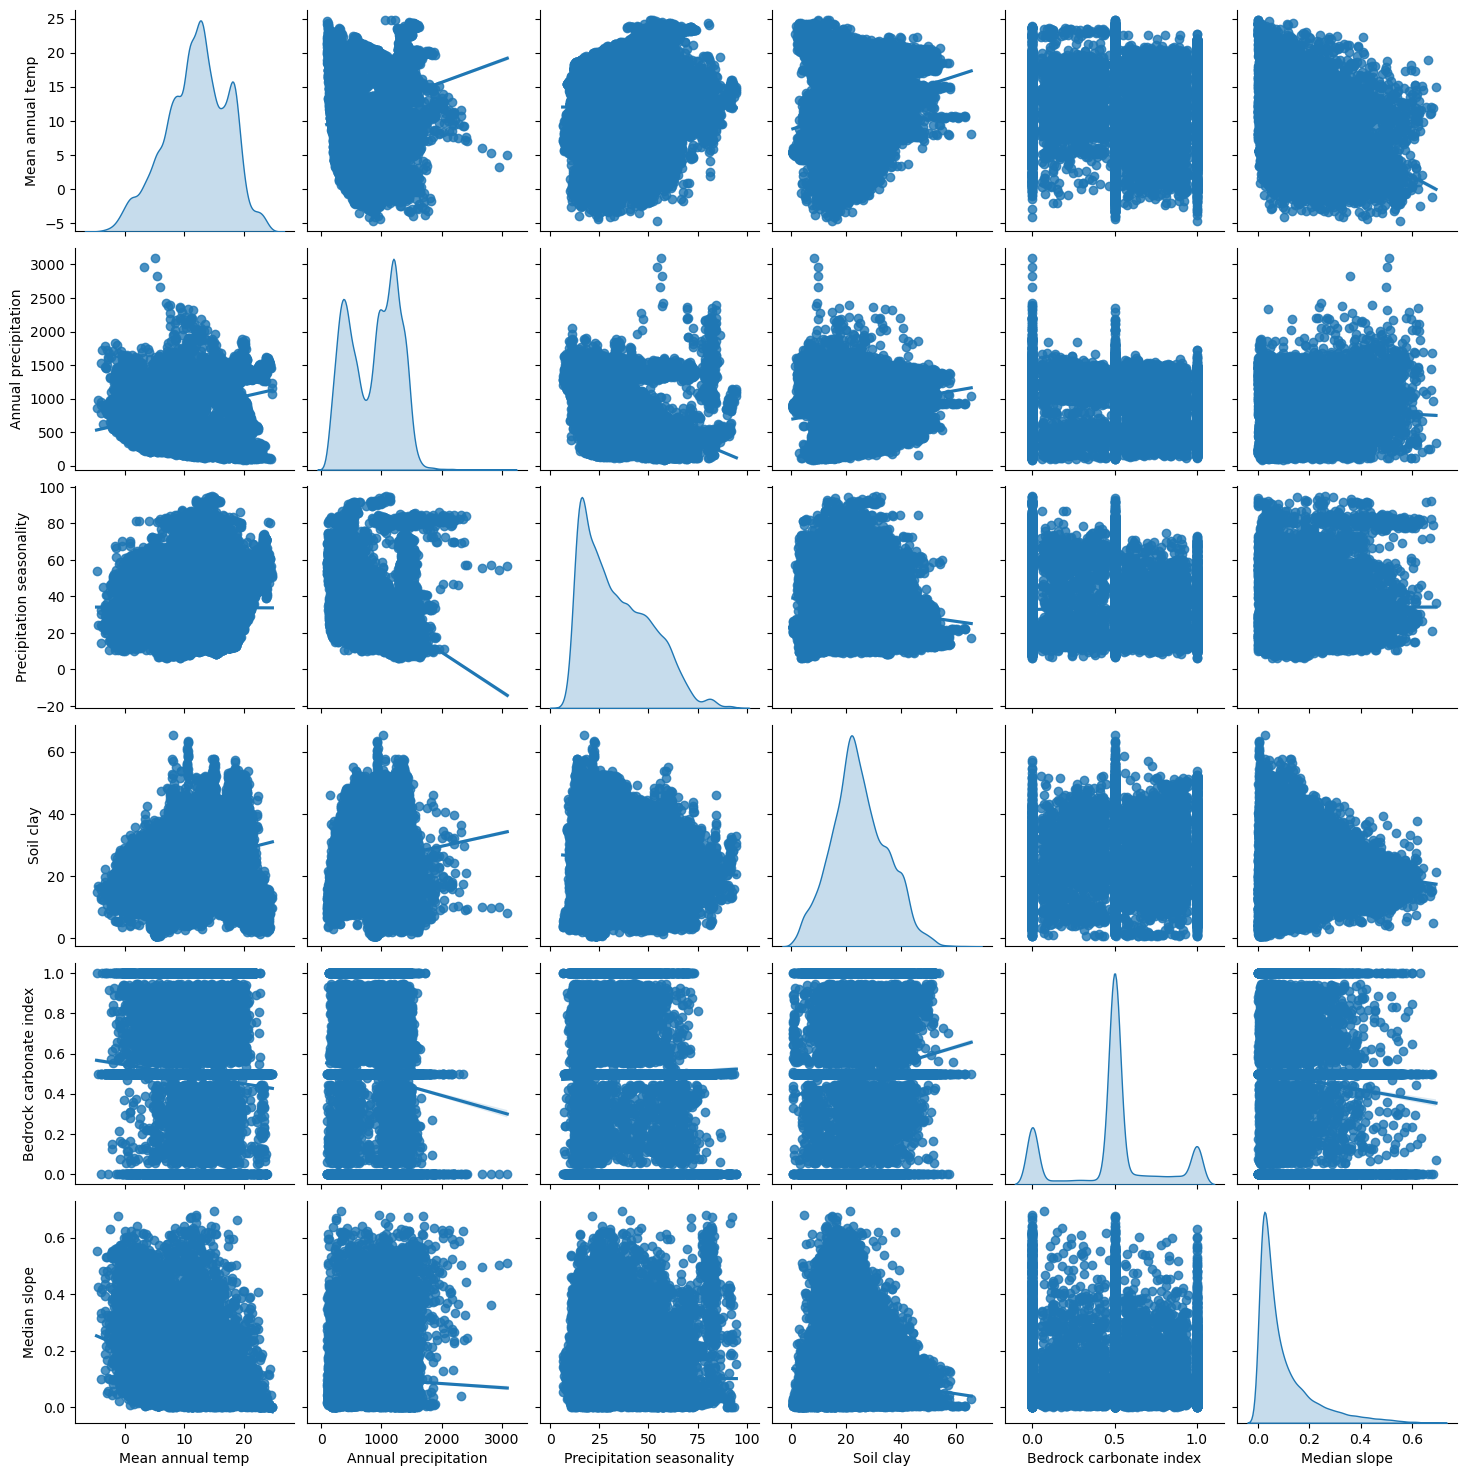

In [70]:
sns.pairplot(X_sel, kind="reg", diag_kind='kde')

In [71]:
clf = xgboost.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train_sel,y_train, eval_set = [(X_test_sel, y_test)])

[0]	validation_0-logloss:0.42835
[1]	validation_0-logloss:0.39753


[2]	validation_0-logloss:0.37988
[3]	validation_0-logloss:0.36787
[4]	validation_0-logloss:0.35974
[5]	validation_0-logloss:0.35542
[6]	validation_0-logloss:0.35233
[7]	validation_0-logloss:0.34816
[8]	validation_0-logloss:0.34573
[9]	validation_0-logloss:0.34439
[10]	validation_0-logloss:0.34289
[11]	validation_0-logloss:0.34223
[12]	validation_0-logloss:0.34099
[13]	validation_0-logloss:0.33943
[14]	validation_0-logloss:0.33874
[15]	validation_0-logloss:0.33810
[16]	validation_0-logloss:0.33758
[17]	validation_0-logloss:0.33636
[18]	validation_0-logloss:0.33617
[19]	validation_0-logloss:0.33560
[20]	validation_0-logloss:0.33568
[21]	validation_0-logloss:0.33550
[22]	validation_0-logloss:0.33487
[23]	validation_0-logloss:0.33389
[24]	validation_0-logloss:0.33352
[25]	validation_0-logloss:0.33362
[26]	validation_0-logloss:0.33239
[27]	validation_0-logloss:0.33133
[28]	validation_0-logloss:0.33114
[29]	validation_0-logloss:0.33110
[30]	validation_0-logloss:0.33120
[31]	validation_0-logl

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [72]:
clf.score(X_test_sel, y_test)

0.8671896504266446

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

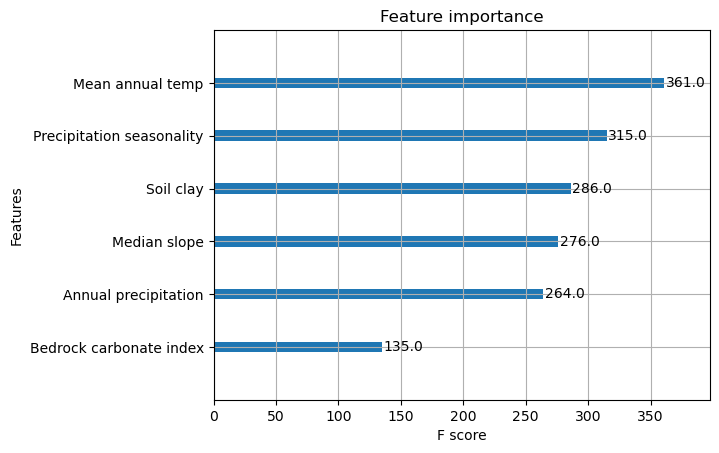

In [73]:
xgboost.plot_importance(clf)

In [86]:
X500 = shap.utils.sample(X_train_sel, 500)
explainer = shap.Explainer(clf.predict, X500)
Exp = explainer(X_test_sel[::10])

In [87]:
clustering = shap.utils.hclust(X_train_sel, y_train)

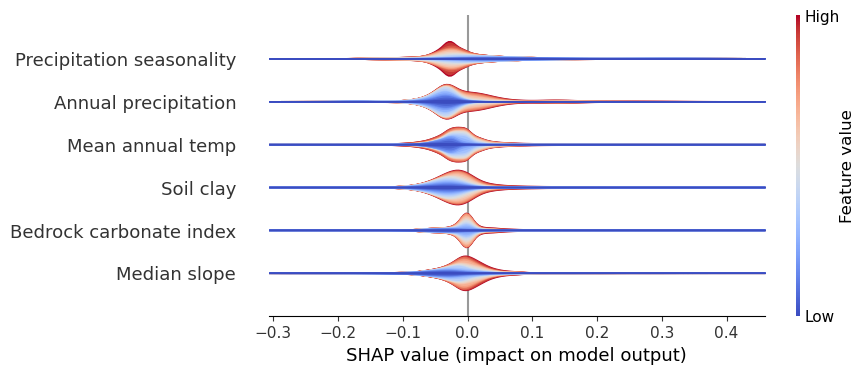

In [162]:
shap.plots.violin(Exp, plot_type='layered_violin')

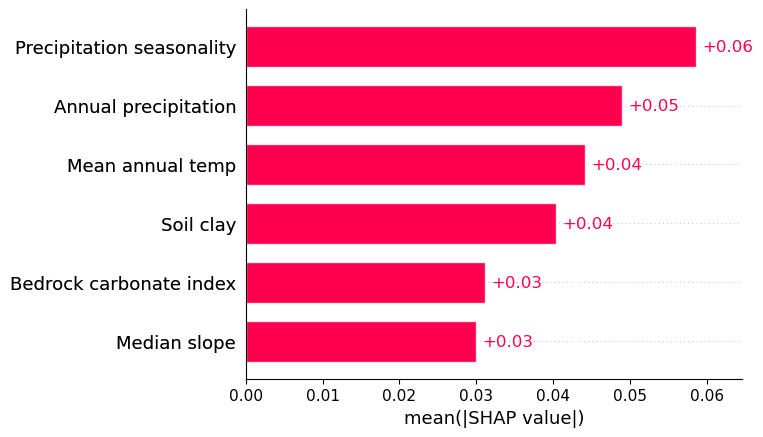

In [168]:
fig, ax = plt.subplots()
shap.plots.bar(Exp, ax=ax)# clustering=clustering, clustering_cutoff=0.8)
fig.tight_layout()
fig.savefig('Mean-SHAP-classifier.png')

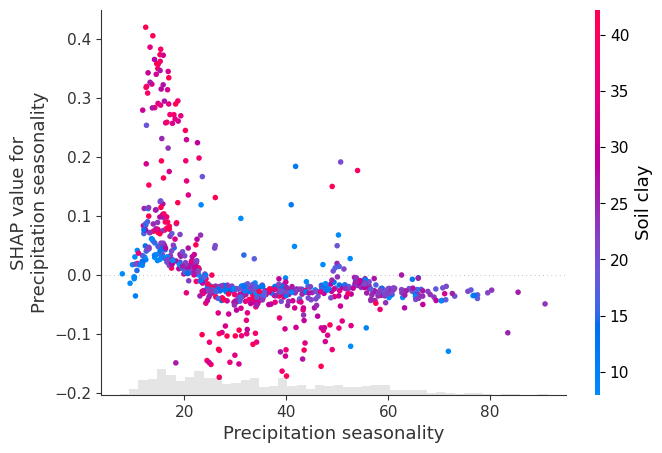

In [91]:
shap.plots.scatter(Exp[:,"Precipitation seasonality"], color=Exp)#[:,"Bedrock carbonate index"])

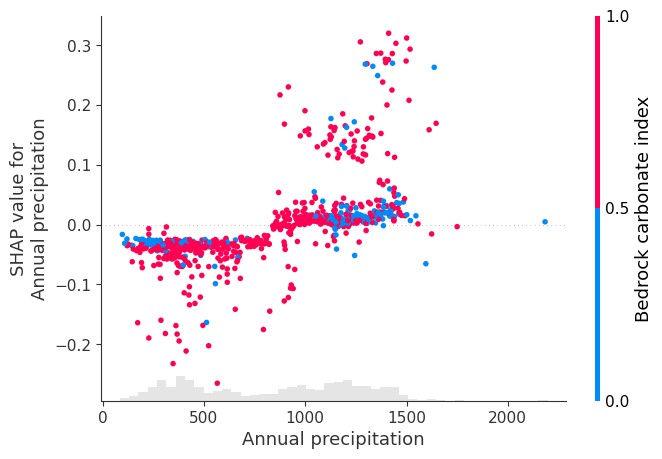

In [92]:
shap.plots.scatter(Exp[:,"Annual precipitation"], color=Exp)

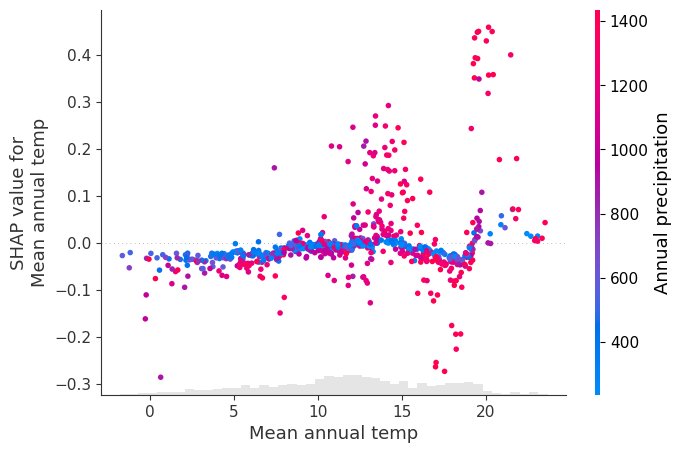

In [93]:
shap.plots.scatter(Exp[:,"Mean annual temp"], color=Exp)


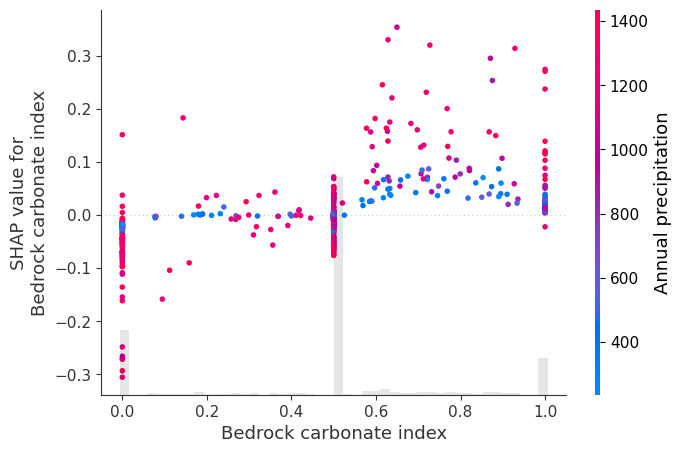

In [94]:
shap.plots.scatter(Exp[:,"Bedrock carbonate index"], color=Exp)

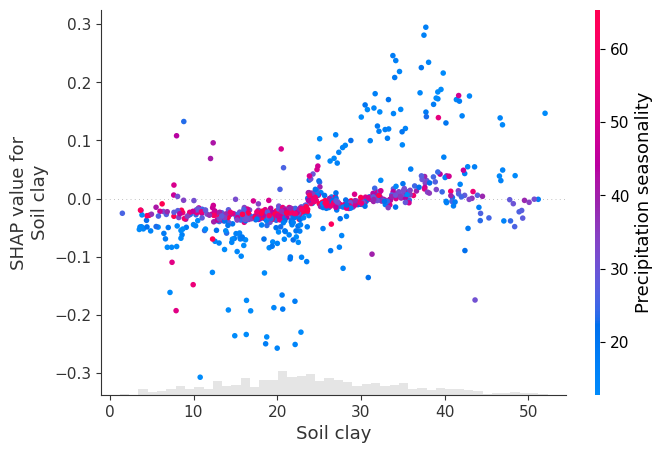

In [95]:
shap.plots.scatter(Exp[:,"Soil clay"], color=Exp)

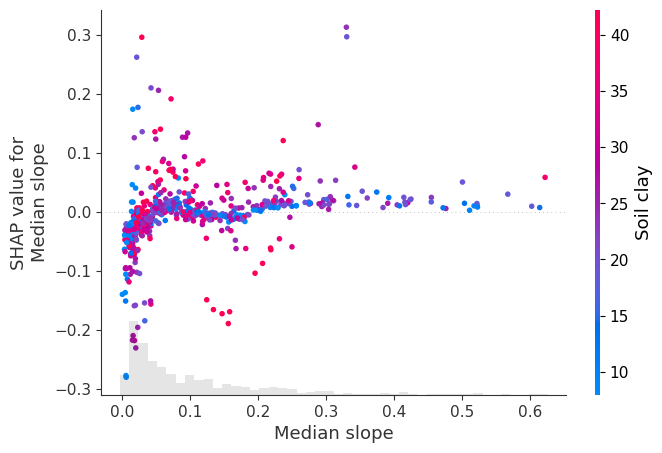

In [96]:
shap.plots.scatter(Exp[:,"Median slope"], color=Exp)

### Regression for non-zero p_karst

In [149]:
XY = p_karst_with_controls[p_karst_with_controls.p_karst>0].loc[:, ['Mean annual temp', 
       'Annual precipitation', 'Precipitation seasonality',
       'Soil clay', 'Bedrock exposure', 'Bedrock carbonate index', 
       'Median slope','p_karst', ]].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['Mean annual temp', 
       'Annual precipitation', 'Precipitation seasonality',
       'Soil clay', 'Bedrock exposure', 'Bedrock carbonate index', 
       'Median slope',
         ]]


Y = np.log10(XY.p_karst)
#X['dominant_r'] = X['dominant_r'].astype('category')
#Y = XY.p_karst > 0
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5510 entries, 11 to 29050
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Mean annual temp           5510 non-null   float64
 1   Annual precipitation       5510 non-null   float64
 2   Precipitation seasonality  5510 non-null   float64
 3   Soil clay                  5510 non-null   float64
 4   Bedrock exposure           5510 non-null   float64
 5   Bedrock carbonate index    5510 non-null   float64
 6   Median slope               5510 non-null   float64
dtypes: float64(7)
memory usage: 344.4 KB


In [157]:
regmod = xgboost.XGBRegressor(tree_method="hist", early_stopping_rounds=2)
regmod.fit(X_train,y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-rmse:0.80355
[1]	validation_0-rmse:0.77746
[2]	validation_0-rmse:0.75971
[3]	validation_0-rmse:0.74589
[4]	validation_0-rmse:0.73758
[5]	validation_0-rmse:0.73440
[6]	validation_0-rmse:0.72949
[7]	validation_0-rmse:0.73037
[8]	validation_0-rmse:0.72345
[9]	validation_0-rmse:0.72331
[10]	validation_0-rmse:0.72333
[11]	validation_0-rmse:0.72001
[12]	validation_0-rmse:0.71756
[13]	validation_0-rmse:0.71660
[14]	validation_0-rmse:0.71511
[15]	validation_0-rmse:0.71393
[16]	validation_0-rmse:0.71483
[17]	validation_0-rmse:0.71380
[18]	validation_0-rmse:0.71435
[19]	validation_0-rmse:0.71450
[20]	validation_0-rmse:0.71459
[21]	validation_0-rmse:0.71466


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [158]:
regmod.score(X_test, y_test)

0.3018674505267337

Text(0, 0.5, 'Predicted log(P_karst)')

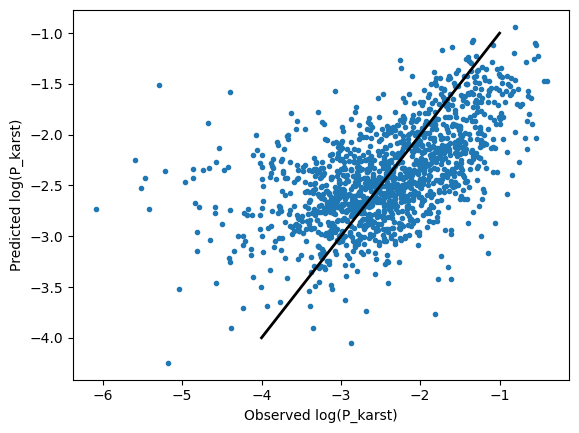

In [159]:
plt.plot(y_test, regmod.predict(X_test), '.')
plt.plot([-4,-1], [-4,-1], 'k-', lw=2)
plt.xlabel('Observed log(P_karst)')
plt.ylabel('Predicted log(P_karst)')

In [130]:
X500 = shap.utils.sample(X_train, 500)
explainer_reg = shap.Explainer(regmod.predict, X500)
Exp_reg = explainer_reg(X_test)

ExactExplainer explainer: 1379it [00:21, 34.74it/s]                          


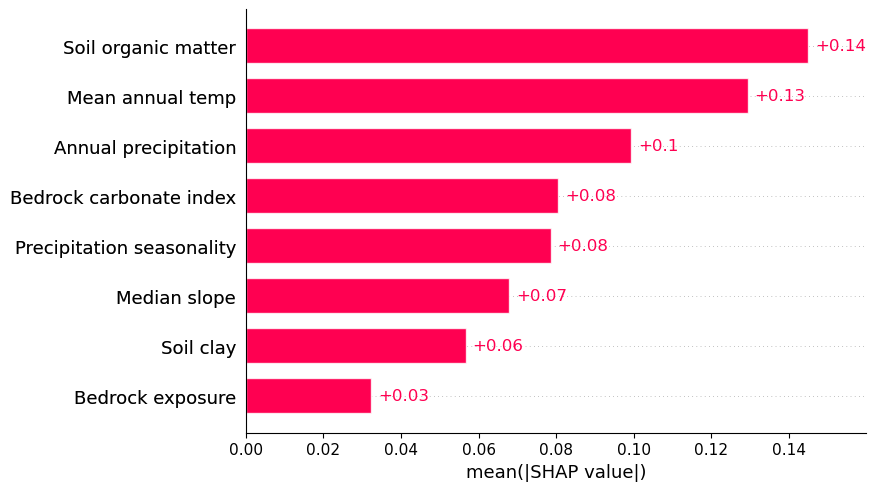

In [131]:
shap.plots.bar(Exp_reg)
shap.plots.bar()

In [144]:
ax

[]

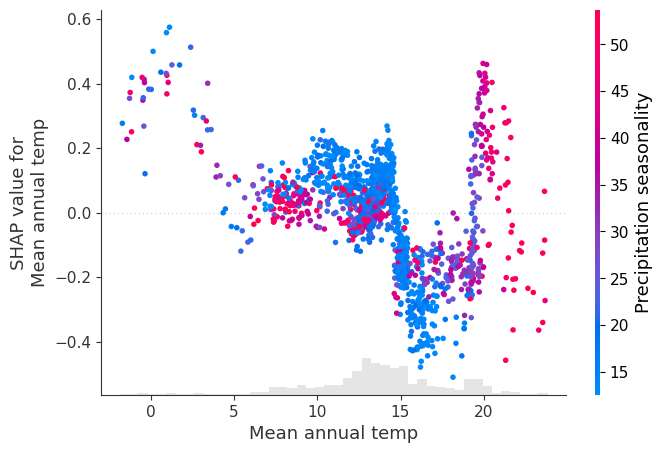

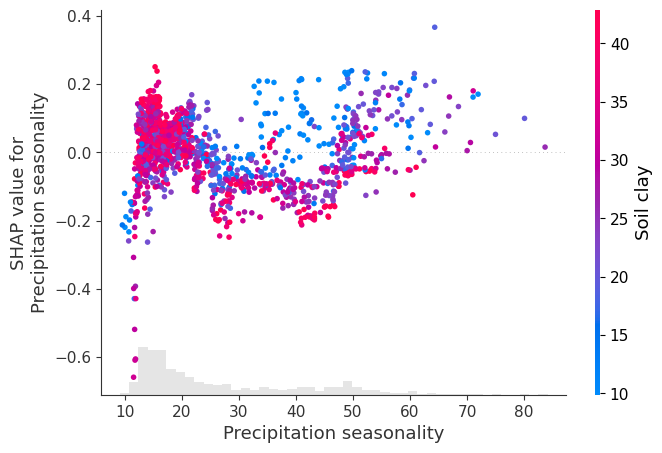

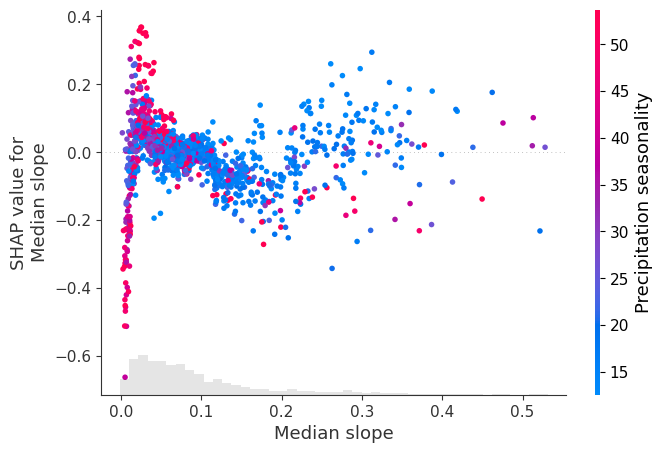

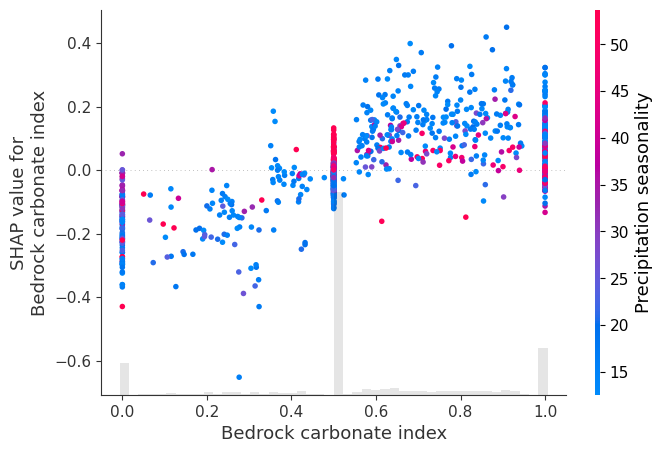

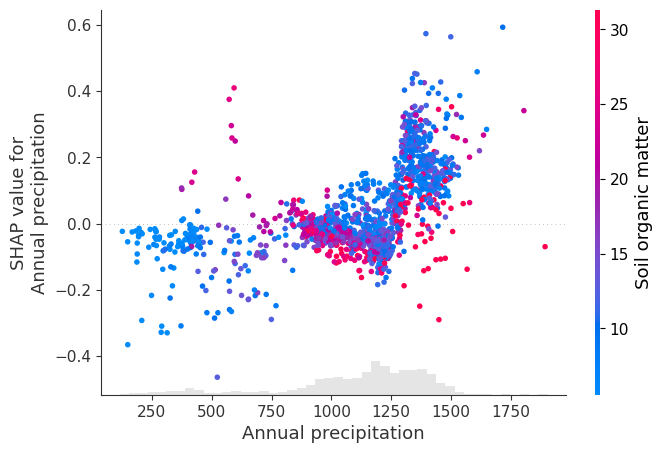

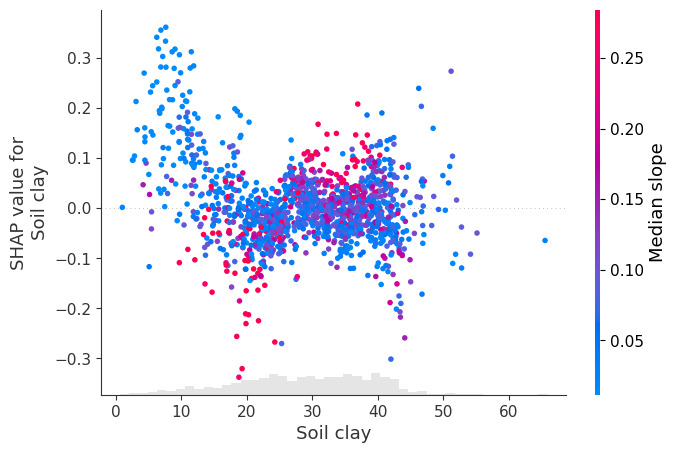

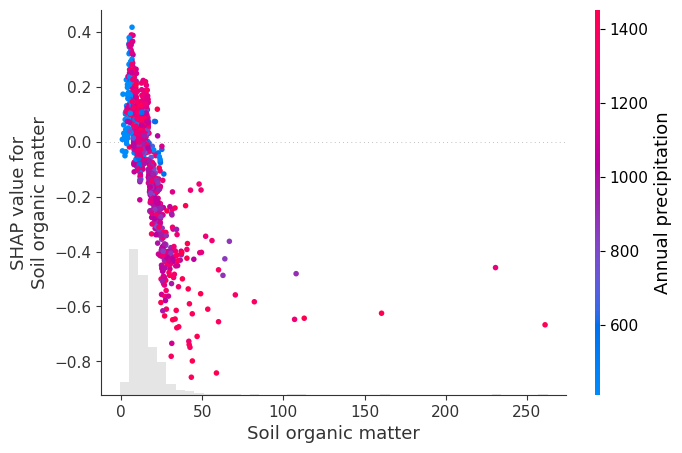

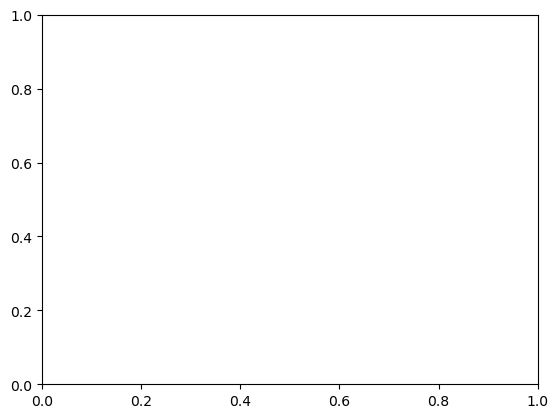

In [148]:
#shap.plots.bar(Exp_reg)
shap.plots.scatter(Exp_reg[:,"Mean annual temp"], color=Exp_reg[:,"Precipitation seasonality"])
shap.plots.scatter(Exp_reg[:,"Precipitation seasonality"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Median slope"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Bedrock carbonate index"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Annual precipitation"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Soil clay"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Soil organic matter"], color=Exp_reg)
#ax = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim([0,75])

In [29]:
p_karst_nonzero = p_karst_with_controls[p_karst_with_controls.p_karst>0]

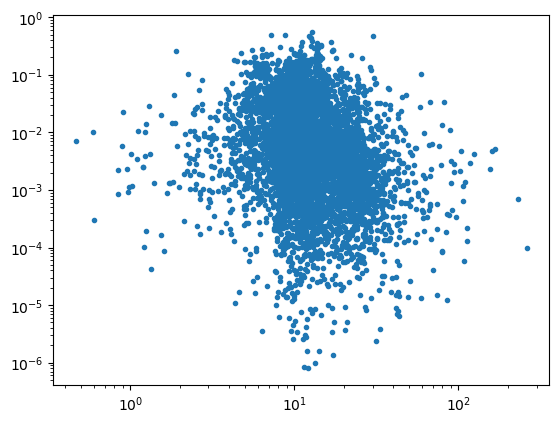

In [30]:
plt.loglog(p_karst_nonzero['Soil organic matter'], p_karst_nonzero.p_karst, '.')

In [31]:
spearmanr(p_karst_nonzero['Soil organic matter'], p_karst_nonzero.p_karst)

SignificanceResult(statistic=-0.2555484972277111, pvalue=6.808307439895262e-83)

In [32]:
def make_displot(param, 
                 p_karst, 
                 controls_df, 
                 trim_to_min_value = 0.,
                 set_zero_to=None,
                 xlabel=None, 
                 ylabel='Percentage karst drained', 
                 log_scale=(False,True),
                 calculate_correlation='Spearman',):
    if set_zero_to is not None:
        p_karst[p_karst==0] = set_zero_to
    
    if trim_to_min_value>0:
        wantidx = p_karst>trim_to_min_value
        x = controls_df[param][wantidx]
        y = p_karst[wantidx]
#    elif trim_zero:
#        non_zero_p_karst = p_karst>0
#        x = controls_df[param][non_zero_p_karst]
#        y = p_karst[non_zero_p_karst]    
    else:
        x = controls_df[param]
        y = p_karst
    

    sns.displot(x=x,
            y=y,
            log_scale=log_scale,
            )
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    rstring = None
    if calculate_correlation == 'Spearman':
        r, p = spearmanr(x, y, nan_policy='omit')
        rstring = 'rho='+str(r)[:5]
    #if calculate_correlation == 'Pearson':
    #    r, p = pearsonr(x, y, nan_policy='omit')
    #    rstring = 'R='+str(r)[:5]
    if rstring is not None:
        ax = plt.gca()
        plt.text(0.05,0.95, rstring, transform = ax.transAxes)



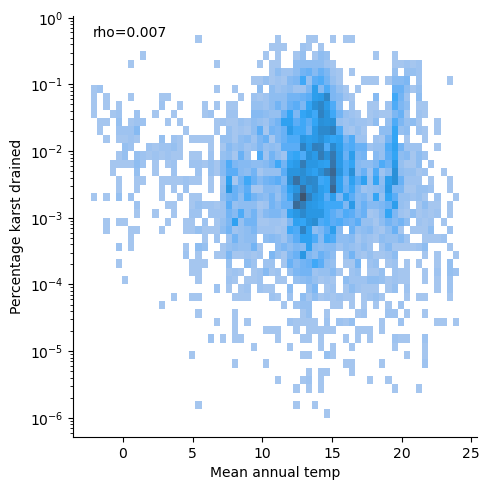

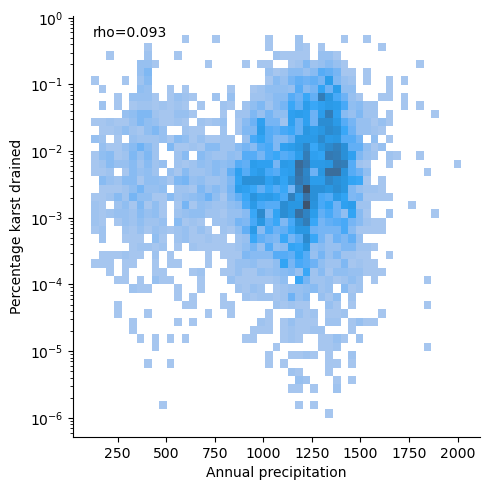

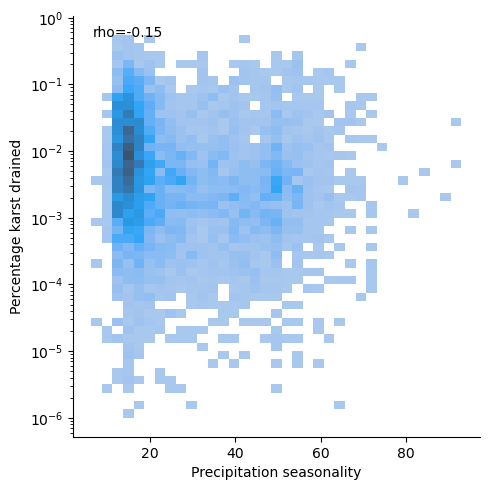

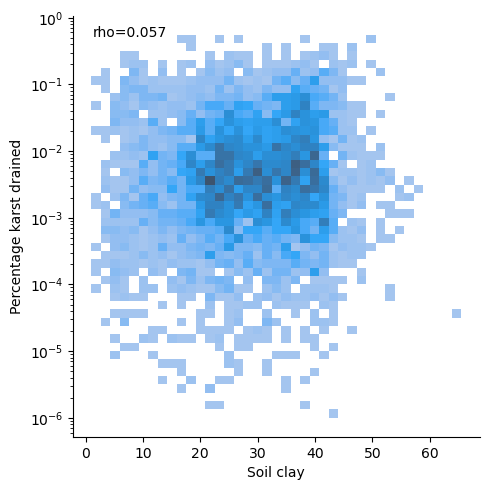

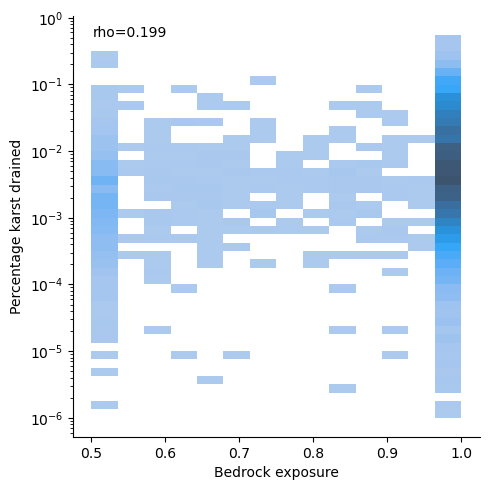

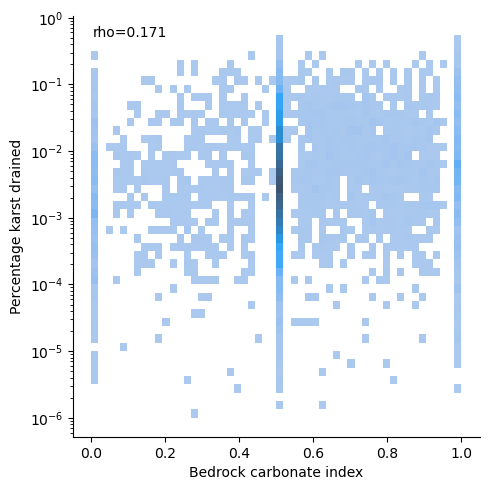

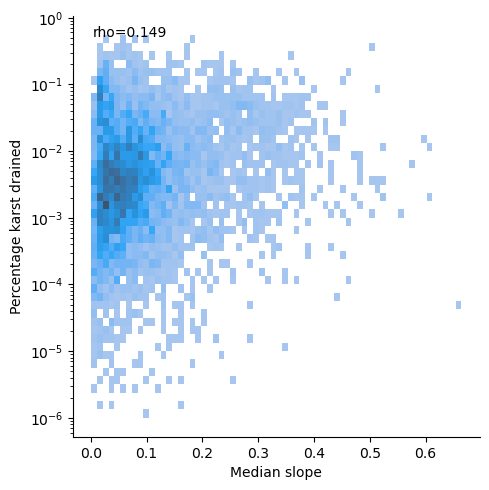

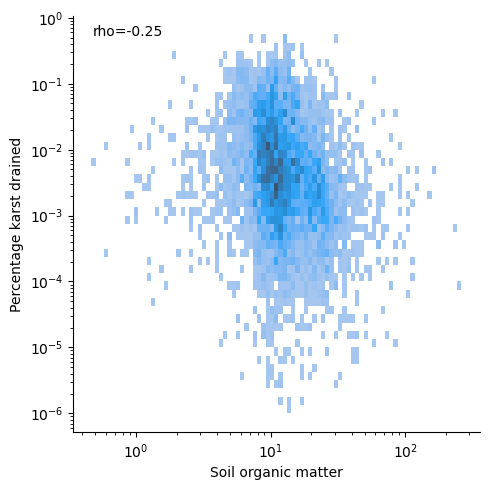

In [33]:
want_params = X.keys().to_list()
want_params.append('Soil organic matter')
for param in want_params:
    if param == 'Soil organic matter':
        logx = True
        logy = True
    else:
        logx = False
        logy = True
    make_displot(param,
                 p_karst_with_controls.p_karst.copy(),
                 p_karst_with_controls,
                 trim_to_min_value=1e-6,
                 log_scale=(logx,logy)
                 )

(3, 50)

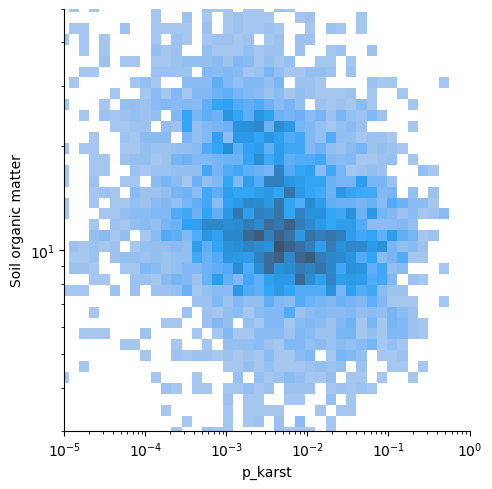

In [34]:
sns.displot(x=p_karst_nonzero.p_karst, y=p_karst_nonzero['Soil organic matter'], log_scale=(True,True))
plt.xlim([1e-5,1])
plt.ylim([3,50])

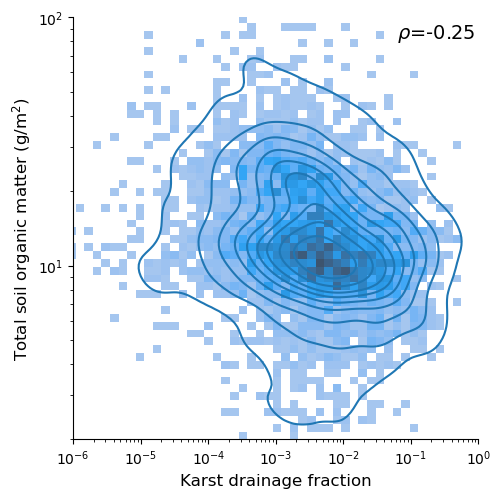

In [177]:
r, p = spearmanr(p_karst_nonzero.p_karst, p_karst_nonzero['Soil organic matter'], nan_policy='omit')
rstring = r'$\rho$='+str(r)[:5]

sns.displot(x=p_karst_nonzero.p_karst, y=p_karst_nonzero['Soil organic matter'], log_scale=(True,True))
sns.kdeplot(x=p_karst_nonzero.p_karst, y=p_karst_nonzero['Soil organic matter'], log_scale=(True,True))
plt.xlim([1e-6,1])
plt.ylim([2,100])
ax = plt.gca()
plt.text(0.8,0.95, rstring, transform = ax.transAxes, fontsize=14)
plt.xlabel('Karst drainage fraction', fontsize=12)
plt.ylabel(r'Total soil organic matter (g/m$^2$)', fontsize=12)
plt.savefig('Organic-matter-correlation.png')

/tmp/ipykernel_173352/954443831.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Nonzero Karst Drainage', 'Zero Karst Drainage'])


Text(0, 0.5, 'Soil organic matter')

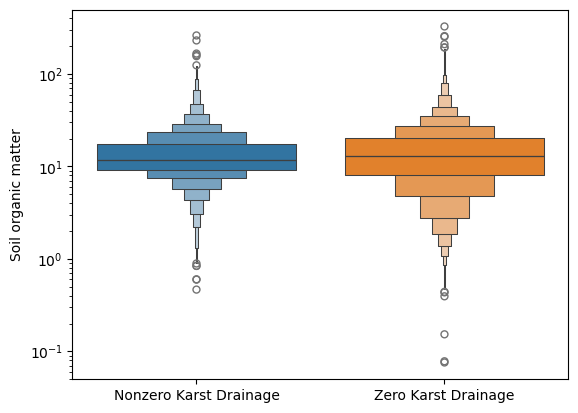

In [125]:
p_karst_zero = p_karst_with_controls[p_karst_with_controls.p_karst==0]
ax = sns.boxenplot([p_karst_nonzero['Soil organic matter'].values, p_karst_zero['Soil organic matter'].values],log_scale=True, )
ax.set_xticklabels(['Nonzero Karst Drainage', 'Zero Karst Drainage'])
plt.ylabel('Soil organic matter')

### Exploring rock type

In [36]:
rocktypes = p_karst_with_controls.dominant_r.unique()
rocktypes

array(['dolostone (dolomite)', 'None', 'shale', 'limestone', 'sandstone',
       'carbonate', 'sand', 'clay or mud', 'siltstone', 'argillite',
       'conglomerate', 'mixed clastic/carbonate', 'calcarenite',
       'mudstone', 'marble', 'silt', 'residuum',
       'fine-grained mixed clastic', 'medium-grained mixed clastic',
       'meta-argillite', 'chert', 'schist', 'mica schist', 'slate',
       'clastic', 'dolostone', 'arkose', 'gneiss', 'olistostrome', nan,
       'metasedimentary rock', 'arenite', 'quartzite', 'calcareous sand',
       'calc-silicate rock', 'sedimentary rock', 'phyllite', 'claystone',
       'biotite gneiss', 'mylonite', 'black shale', 'greenstone',
       'serpentinite', 'Sandstone', 'gravel', 'rhyolite', 'hornfels',
       'terrace', 'dolomite', 'landslide', 'graywacke', 'orthoquartzite',
       'melange'], dtype=object)

In [37]:
rocktype_dict = {}
for rock in rocktypes:
    count = len(p_karst_with_controls[p_karst_with_controls.dominant_r==rock])
    #print(rock, count)
    rocktype_dict[rock] = count
rocktype_df = pd.Series(rocktype_dict)
rocktype_df.sort_values(ascending=False)

limestone                       9253
None                            5521
sandstone                       2805
shale                           2618
dolostone (dolomite)            2326
carbonate                       1557
sand                            1136
fine-grained mixed clastic       715
clay or mud                      570
marble                           323
arkose                           278
mixed clastic/carbonate          216
meta-argillite                   208
argillite                        207
mudstone                         167
schist                           108
quartzite                         96
sedimentary rock                  87
conglomerate                      85
clastic                           80
calcarenite                       73
medium-grained mixed clastic      70
chert                             67
calcareous sand                   61
metasedimentary rock              50
residuum                          47
siltstone                         44
s

In [38]:


limestones = p_karst_with_controls[p_karst_with_controls['dominant_r']=='limestone']
sandstones = p_karst_with_controls[p_karst_with_controls['dominant_r']=='sandstone']
dolomites = p_karst_with_controls[p_karst_with_controls['dominant_r']=='dolostone (dolomite)']
shales = p_karst_with_controls[p_karst_with_controls['dominant_r']=='shale']


In [39]:
common_rocks = ['limestone', 'sandstone', 'dolostone (dolomite)', 'shale']
p_with_common_rocks = p_karst_with_controls[p_karst_with_controls.dominant_r.isin(common_rocks)]



/tmp/ipykernel_173352/1328652519.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['Shale', 'Limestone', 'Dolomite', 'Sandstone'], fontsize=12)


[Text(0, 0, 'Shale'),
 Text(1, 0, 'Limestone'),
 Text(2, 0, 'Dolomite'),
 Text(3, 0, 'Sandstone')]

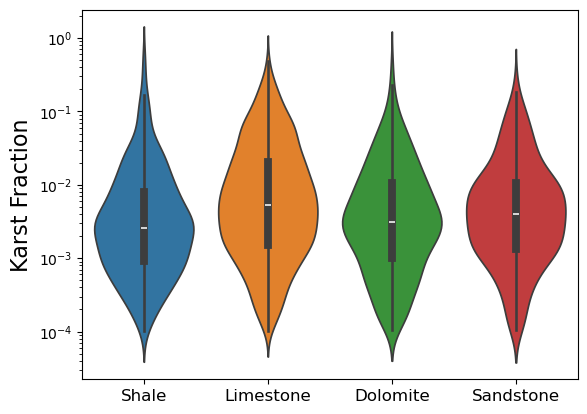

In [40]:
p_with_common_rocks_no_zeros = p_with_common_rocks[p_with_common_rocks.p_karst>1e-4]
g = sns.violinplot(p_with_common_rocks_no_zeros, x='dominant_r', y='p_karst', log_scale=True, hue='dominant_r')
plt.ylabel('Karst Fraction', fontsize=16)
plt.xlabel('')
g.set_xticklabels(['Shale', 'Limestone', 'Dolomite', 'Sandstone'], fontsize=12)

In [41]:
XY = p_with_common_rocks_no_zeros.loc[:, ['Mean annual temp', 
       'Annual precipitation', 'Precipitation seasonality',
       'Soil clay', 'Bedrock exposure', 'Bedrock carbonate index', 
       'Median slope','p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['Mean annual temp', 
       'Annual precipitation', 'Precipitation seasonality',
       'Soil clay', 'Bedrock exposure', 'Bedrock carbonate index', 
       'Median slope',
         ]]


Y = np.log10(XY.p_karst)
#X['dominant_r'] = X['dominant_r'].astype('category')
#Y = XY.p_karst > 0
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 27 to 29050
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Mean annual temp           3182 non-null   float64
 1   Annual precipitation       3182 non-null   float64
 2   Precipitation seasonality  3182 non-null   float64
 3   Soil clay                  3182 non-null   float64
 4   Bedrock exposure           3182 non-null   float64
 5   Bedrock carbonate index    3182 non-null   float64
 6   Median slope               3182 non-null   float64
dtypes: float64(7)
memory usage: 327.9 KB


In [42]:
regmod = xgboost.XGBRegressor(tree_method="hist", early_stopping_rounds=2)
regmod.fit(X_train,y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-rmse:0.71026


[1]	validation_0-rmse:0.67264
[2]	validation_0-rmse:0.65475
[3]	validation_0-rmse:0.63960
[4]	validation_0-rmse:0.63265
[5]	validation_0-rmse:0.62553
[6]	validation_0-rmse:0.62383
[7]	validation_0-rmse:0.62035
[8]	validation_0-rmse:0.62022
[9]	validation_0-rmse:0.61823
[10]	validation_0-rmse:0.61840
[11]	validation_0-rmse:0.61749
[12]	validation_0-rmse:0.61747
[13]	validation_0-rmse:0.61707
[14]	validation_0-rmse:0.61525
[15]	validation_0-rmse:0.61606
[16]	validation_0-rmse:0.61355
[17]	validation_0-rmse:0.61110
[18]	validation_0-rmse:0.60950
[19]	validation_0-rmse:0.60885
[20]	validation_0-rmse:0.60879
[21]	validation_0-rmse:0.60910
[22]	validation_0-rmse:0.60921


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
regmod.score(X_test,y_test)

0.36548935077424216

Text(0, 0.5, 'Predicted log(P_karst)')

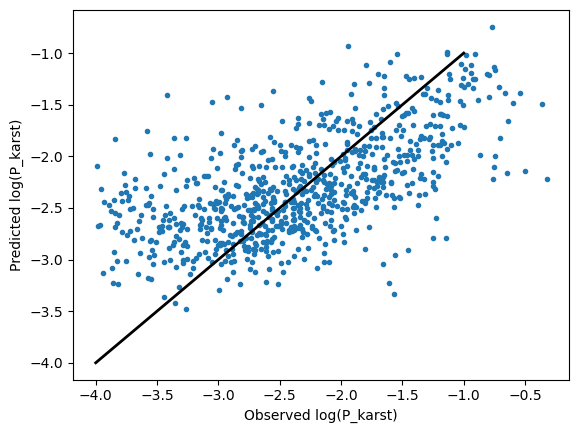

In [44]:
plt.plot(y_test, regmod.predict(X_test), '.')
plt.plot([-4,-1], [-4,-1], 'k-', lw=2)
plt.xlabel('Observed log(P_karst)')
plt.ylabel('Predicted log(P_karst)')

In [45]:
X500 = shap.utils.sample(X_train, 500)
explainer_reg = shap.Explainer(regmod.predict, X500)
Exp_reg = explainer_reg(X_test)

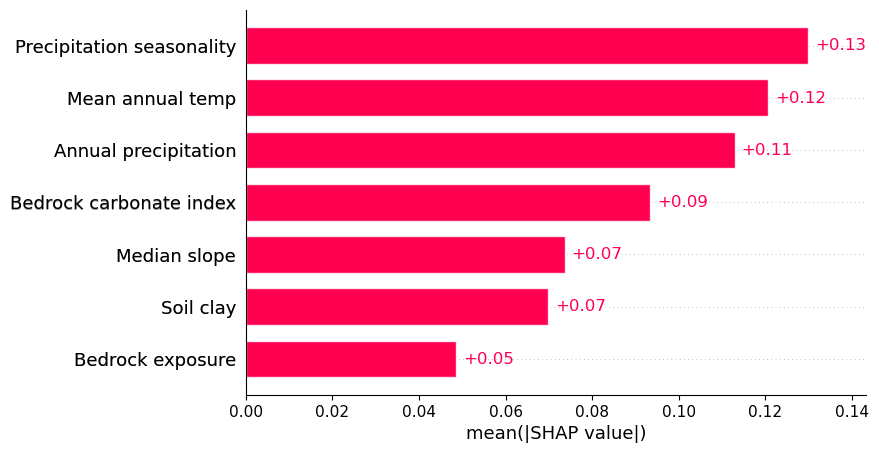

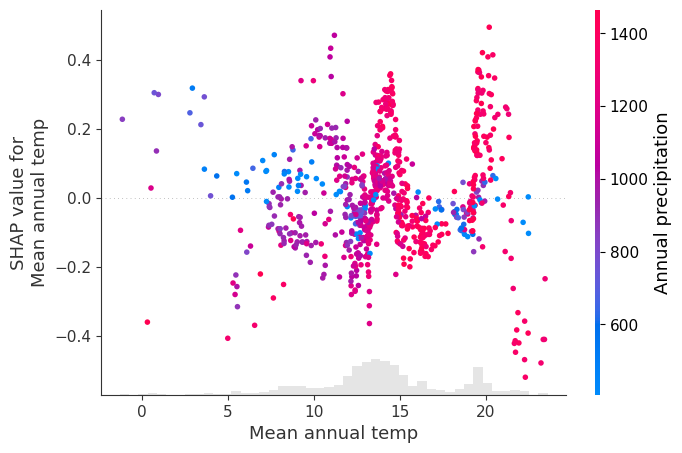

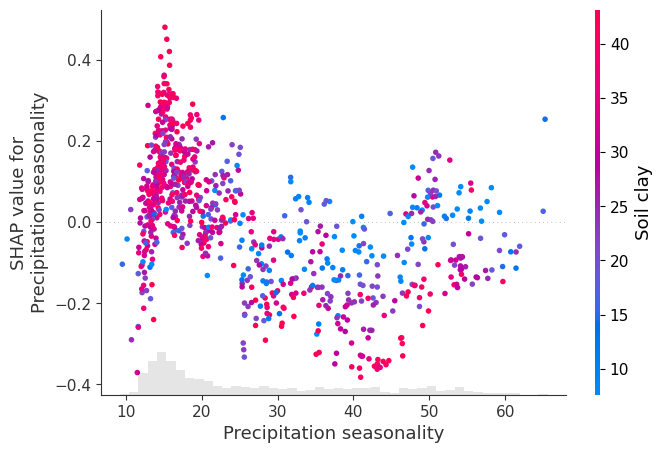

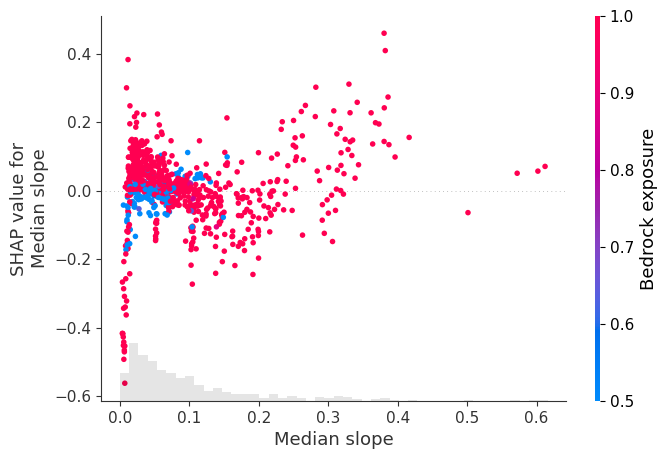

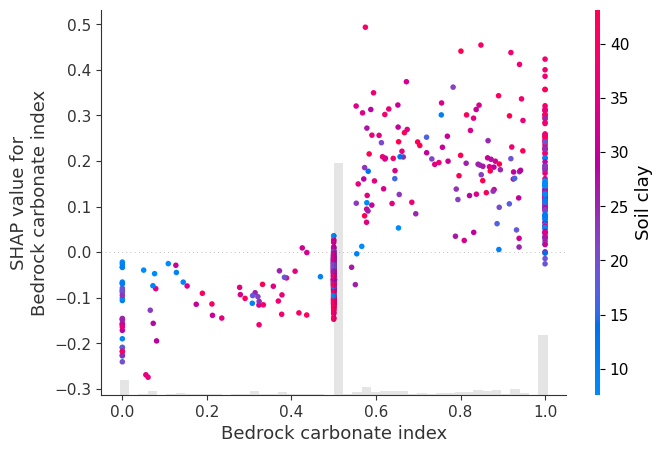

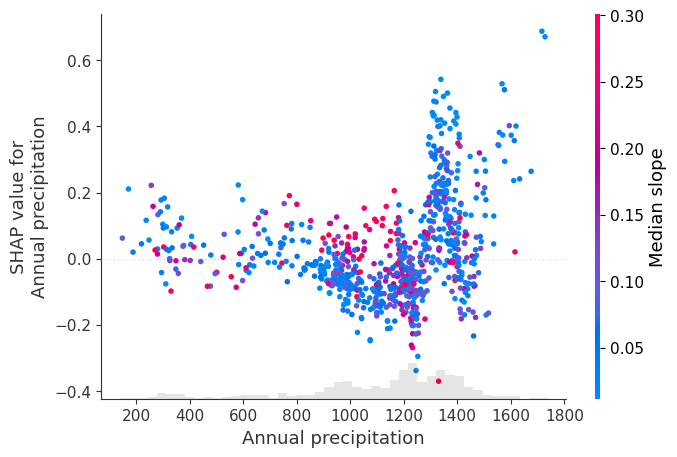

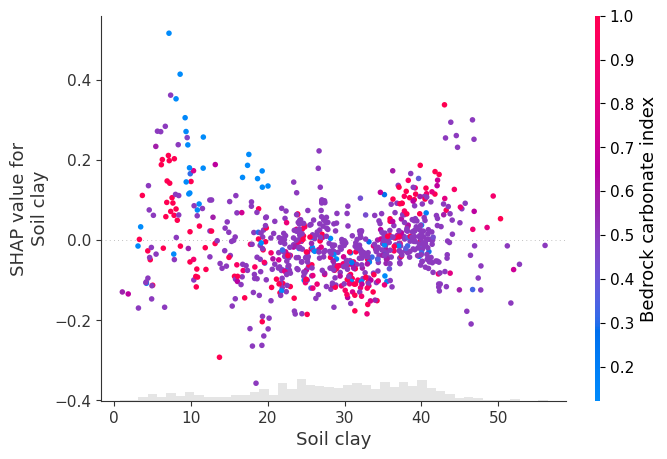

In [46]:
shap.plots.bar(Exp_reg)
shap.plots.scatter(Exp_reg[:,"Mean annual temp"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Precipitation seasonality"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Median slope"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Bedrock carbonate index"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Annual precipitation"], color=Exp_reg)
shap.plots.scatter(Exp_reg[:,"Soil clay"], color=Exp_reg)

Notes from 9/18 meeting
- try adding back in temperature seasonality
- what about porosity/permeability or age?